In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pydotplus

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from sklearn.metrics import precision_recall_curve, roc_curve

%matplotlib inline

In [2]:
# Import the data
df_exam = pd.read_csv('exam.dat', header=None, sep='[1-4]:', engine='python')

n = 3089, d = 5
count(g = 0) = 1089, count(g = 1) = 2000


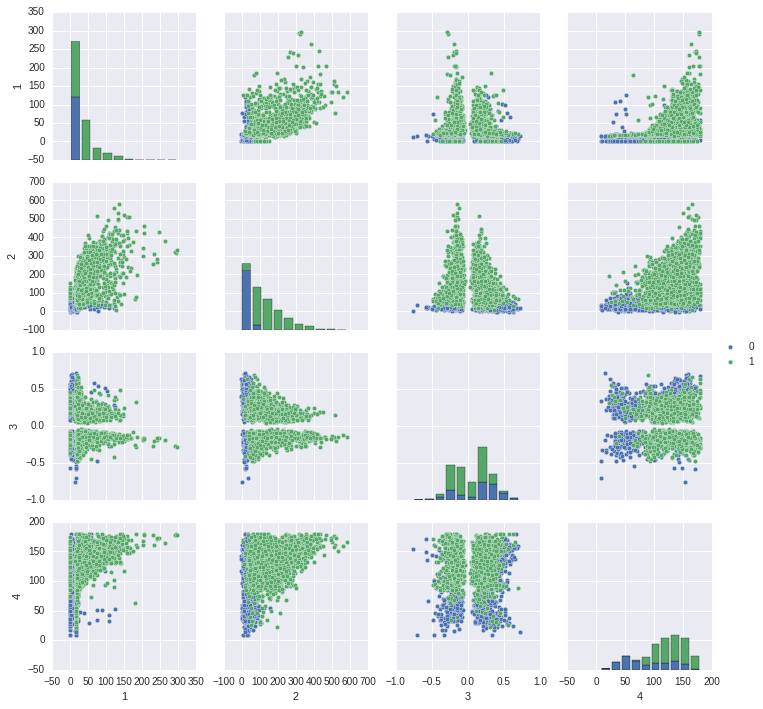

In [3]:
# Summarize
sns.set()
plot_scatterplot = sns.pairplot(df_exam, hue=0, vars=np.arange(1, 5))
plot_scatterplot.savefig("scatterplot.pdf", dpi=10)

print("n = {0}, d = {1}".format(*df_exam.shape))
print("count(g = 0) = {0}, count(g = 1) = {1}".format(sum(df_exam[0] < 0.5), sum(df_exam[0] > 0.5)))

In [4]:
X = df_exam.values[:, 1 :]
g = df_exam.values[:, 0]

X_train, X_test, g_train, g_test = train_test_split (X, g, test_size = 0.25, random_state=33)

mu = np.mean(X_train, axis = 0)
sigma = np.std(X_train, axis = 0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

cv = KFold(X_train.shape[0], n_folds=10, random_state=8) # Generate the cross validation labels

In [5]:
classifiers = dict()
params_key = dict()
params_grid = dict()

score_train = dict()
score_test = dict()
score_cv_mean = dict()
score_cv_std = dict()

# KNN classifier
k_range = np.arange(1, 100, 2) # Range of parameter n_neighbors
classifiers["knn"] = KNeighborsClassifier()
params_key["knn"] = "n_neighbors"
params_grid["knn"] = dict([(params_key["knn"], k_range), ])

# Decision tree classifier
depth_range = np.arange(1, 21) # Range of parameter n_neighbors
classifiers["tree"] = DecisionTreeClassifier()
params_key["tree"] = "max_depth"
params_grid["tree"] = dict([(params_key["tree"], depth_range), ])

# Train all the classifiers
for classifier in classifiers.keys():
    
    print("Tuning {0}...".format(classifier))
    
    grid = GridSearchCV(classifiers[classifier], param_grid=params_grid[classifier], cv=cv , verbose=0, n_jobs=4)
    grid.fit(X_train, g_train)
    
    score_train[classifier] = np.empty(len(params_grid[classifier][params_key[classifier]]), dtype="float64")
    score_test[classifier] = np.empty(len(params_grid[classifier][params_key[classifier]]), dtype="float64")
    
    for idx, p in enumerate(params_grid[classifier][params_key[classifier]]):
        classifiers[classifier].set_params(**dict([(params_key[classifier], p), ]))
        classifiers[classifier].fit(X_train, g_train)
    
        score_train[classifier][idx] = classifiers[classifier].score(X_train, g_train)
        score_test[classifier][idx] = classifiers[classifier].score(X_test, g_test)
        
    score_cv_mean[classifier] = [entry[1] for entry in grid.grid_scores_]
    score_cv_std[classifier] = [np.std(entry[2]) for entry in grid.grid_scores_] 

Tuning knn...
Tuning tree...


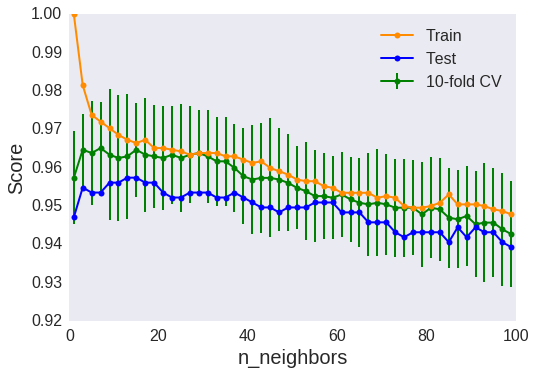

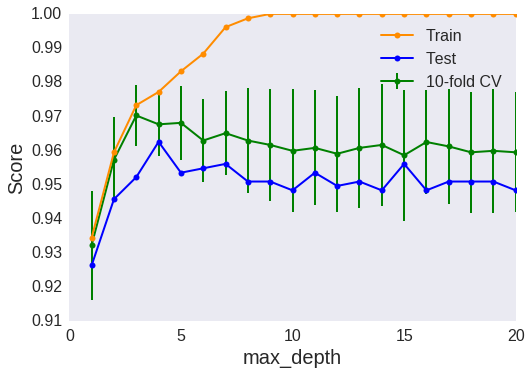

In [6]:
# Plot the tuning of model parameters
axis_font = {'size': '20'}
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

for classifier in classifiers.keys():
    plt.figure()

    plt.errorbar(params_grid[classifier][params_key[classifier]],\
                 score_cv_mean[classifier], yerr=score_cv_std[classifier],\
                 color='green', linewidth=2, label='10-fold CV', marker='.', markersize=12)
    plt.plot(params_grid[classifier][params_key[classifier]],\
             score_train[classifier], color='darkorange', linewidth=2, label='Train', marker='.', markersize=12)
    plt.plot(params_grid[classifier][params_key[classifier]],\
             score_test[classifier], color='blue', linewidth=2, label='Test', marker='.', markersize=12)
    
    plt.xlabel(params_key[classifier], **axis_font)
    plt.ylabel('Score', **axis_font)
    plt.grid()
    plt.legend(prop={'size':16})
    plt.savefig('{0}_tuning.pdf'.format(classifier), dpi=10)

In [7]:
# Train the best classifier for each algorithms and evaluate their performances
fpr = dict() # False positive rate
fnr = dict() # False negative rate
precision = dict() # Precision
recall = dict() # Recall
score = dict() # Test score

classifiers["knn"].set_params(n_neighbors=15)
classifiers["tree"].set_params(max_depth=3)

for classifier in classifiers.keys():
    classifiers[classifier].fit(X_train, g_train)
    g_score = classifiers[classifier].predict(X_test)
    
    fpr[classifier], fnr[classifier] = sum((g_test==0) * (g_score==1)) / sum(g_test==0),\
                                       sum((g_test==1) * (g_score==0)) / sum(g_test==1)
        
    
    precision[classifier], recall[classifier] = (1 - fnr[classifier]) /\
                                                (1 - fnr[classifier] + fpr[classifier]),\
                                                (1 - fnr[classifier])/\
                                                (1 - fnr[classifier] + fnr[classifier])
    score[classifier] = classifiers[classifier].score(X_test, g_test)

fpr, fnr, precision, recall, score   

({'knn': 0.063829787234042548, 'tree': 0.085106382978723402},
 {'knn': 0.030549898167006109, 'tree': 0.026476578411405296},
 {'knn': 0.9382260431956384, 'tree': 0.91960704052394593},
 {'knn': 0.96945010183299385, 'tree': 0.97352342158859473},
 {'knn': 0.95730918499353168, 'tree': 0.95213454075032344})

In [8]:
dot_data = StringIO() 

export_graphviz(classifiers["tree"], out_file=dot_data,  
                filled=True, rounded=True,
                class_names=['0', '1'],
                special_characters=True)  
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_pdf('tree.pdf')

True